In [3]:
import numpy as np
import pandas as pd

from scipy.stats import norm
import time

import matplotlib.pyplot as plt

%matplotlib inline

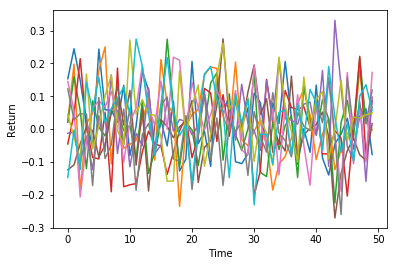

In [4]:


# mu = 0.01, std = 0.10, 1000 bars, 10 assets
mu = 0.01
sigma = 0.10
bars = 1000
num_assets = 10

returns = np.random.normal(mu, sigma, (bars, num_assets))

# Fake asset names
names = ['Asset %s' %i  for i in range(num_assets)]

# Put in a pandas dataframe
returns = pd.DataFrame(returns, columns=names)

# Plot the last 50 bars
plt.plot(returns.head(50))
plt.xlabel('Time')
plt.ylabel('Return');



In [5]:
weights = np.ones((10, 1))
# Normalize
weights = weights / np.sum(weights)

In [7]:
def value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    returns = returns.fillna(0.0)
    # Multiply asset returns by weights to get one weighted portfolio return
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [8]:
value_invested = 1000000

value_at_risk(value_invested, returns, weights, alpha=0.95)

-42815.654481118319

Interpreting this, we say that historically no more than 5% of days resulted in losses more extreme than this, or that on each day your probability of losing this much is less than 5%. Keeping in mind that any forecast like this is just an estimate.

# Normal Case

A special case of VaR is when you assume that the returns follow a given distribution rather than non-parametrically estiamting it historically. In this case a normal VaR would fit our data, because all our returns were simulated form a normal distribution. We can check this by using a normal distribution Cumulative Distribution Function (CDF), which sums the area under a normal curve to figure out how likely certain values are. We'll use an inverse CDF, or PPF, which for a given likelihood will tell us to which value that likelihood corresponds.

Specifically, the closed form formula for Normal VaR is
VaRα(x)=μ−σN−1(α)

In [10]:
# Portfolio mean return is unchanged, but std has to be recomputed
# This is because independent variances sum, but std is sqrt of variance
portfolio_std = np.sqrt( np.power(sigma, 2) * num_assets ) / num_assets

# manually 
(mu - portfolio_std * norm.ppf(0.95)) * value_invested

-42014.838787555738

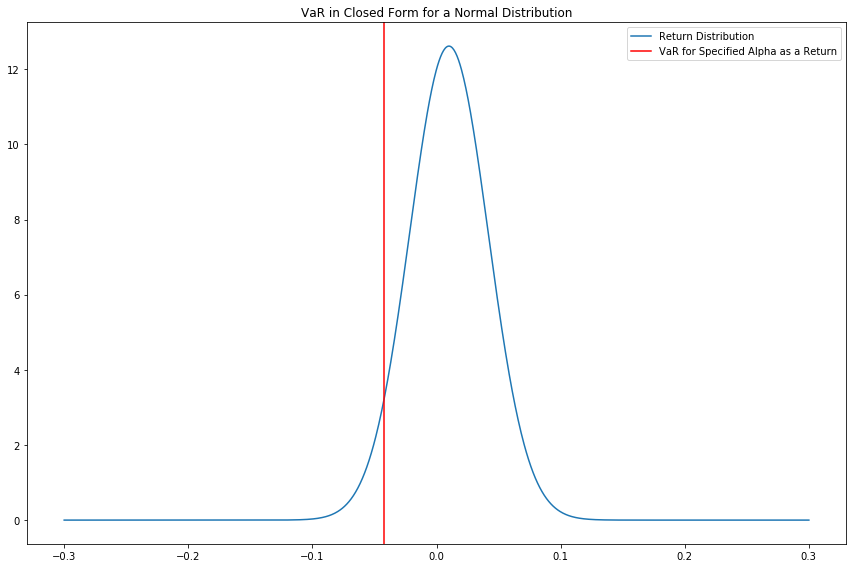

In [18]:
def value_at_risk_N(mu=0, sigma=1.0, alpha=0.95):
    return mu - sigma*norm.ppf(alpha)


x = np.linspace(-3*sigma,3*sigma,1000)
y = norm.pdf(x, loc=mu, scale=portfolio_std)
plt.figure(figsize=(12,8));
plt.plot(x,y)
plt.axvline(value_at_risk_N(mu = 0.01, sigma = portfolio_std, alpha=0.95), color='red', linestyle='solid');
plt.legend(['Return Distribution', 'VaR for Specified Alpha as a Return'])
plt.title('VaR in Closed Form for a Normal Distribution');
plt.tight_layout()

# Historical (Non-Parametric) Case

Historical VaR instead uses historical data to draw a discrete Probability Density Function, or histogram. Then finds the point at which only 100×(1−α)%
of the points are below that return. It returns that return as the VaR return for coverage α.

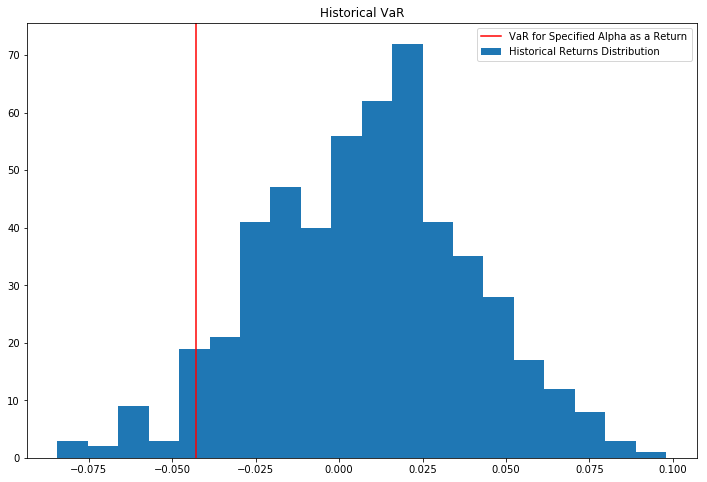

In [21]:
lookback_days = 520
alpha = 0.95
plt.figure(figsize=(12,8))
# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');

# Underlying Distributions Are Not Always Normal

In real financial data the underlying distributions are rarely normal. This is why we prefer historical VaR as opposed to an assumption of an underlying distribution. Historical VaR is also non-parametric, so we aren't at risk of overfitting distribution parameters to some data set.
